In [573]:
import numpy as np
import pandas as pd
import pymatgen as mg
import time
import os
import seaborn as sns
from dcor import distcorr, distcorr_array
import collections

import matplotlib.pyplot as plt
%matplotlib inline

import sys
if '..' not in sys.path:
    sys.path.insert(1,'..')
    
from helpers.calc_chemfeat_2 import Perovskite
from helpers.featurizers import PerovskiteProperty
from helpers import fileload as fl
from helpers.outlier_detect import DataCleaner
import helpers.model_eval as mv

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from ipywidgets import interact, interact_manual, fixed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
#pickledir = os.path.join(tcodir,'scripts/pickles')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots/outliers')
src = 'samples'

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

In [3]:
data = pd.DataFrame()
samples = next(os.walk(os.path.join(datadir,src)))[1]

for sample in samples:
    if sample!='ignore':
        df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
        fl.get_formula(df,overwrite=True)
        df['sample'] = sample
        df.index = df.index + '_' + sample[-4:]
        data = data.append(df,sort=True)

#get el amts after formula normalization - needed for DataCleaner
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    comp = mg.Composition(formula)
    Bsum = sum([comp.get(el) for el in Bsite])
    for el in ['Ba'] + Bsite:
        #normalize to B-site
        data.loc[idx,el] = comp.get(el)/Bsum    
    
    
#remove negative values
data = data.loc[data['Sigma_elec']>=0,:]

data['log_sigma'] = np.log10(data['Sigma_elec'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A34BD8390>]],
      dtype=object)

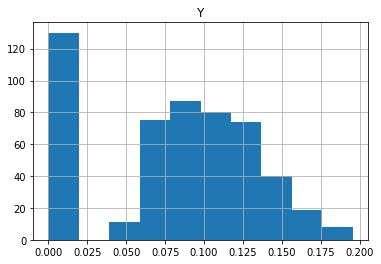

In [4]:
data.hist('Y')

## Remove outliers

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
[0 1 2 3]
2


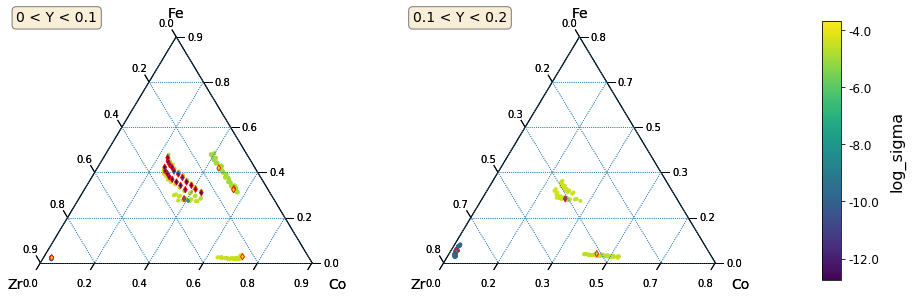

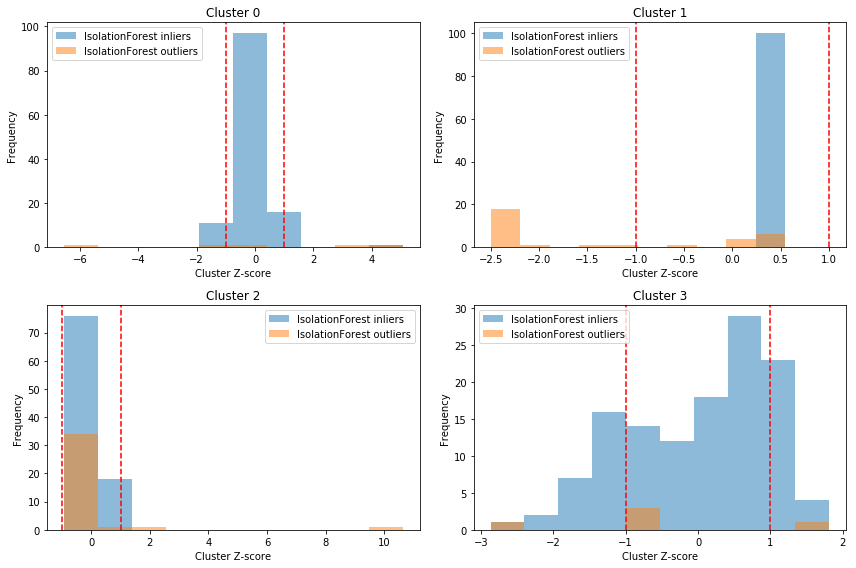

In [175]:
%matplotlib inline
dc = DataCleaner(data,'log_sigma',comp_dims=['Ba'] + Bsite)
dc.set_IF_params(contamination=0.15)
dc.fit_predict(z_thresh=1)
plot_args = dict(slice_axis='Y',slice_starts=[0,0.1],slice_widths=0.1,tern_axes=['Co','Fe','Zr'])

dc.highlight_outliers(**plot_args)
dc.cluster_hist()

Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.4, 0.98, 'Outliers')

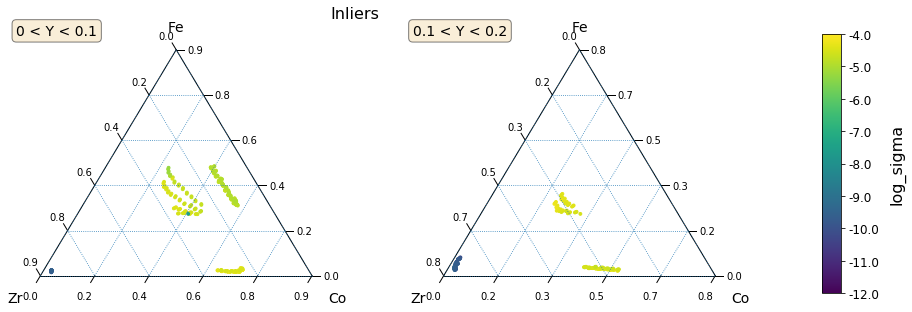

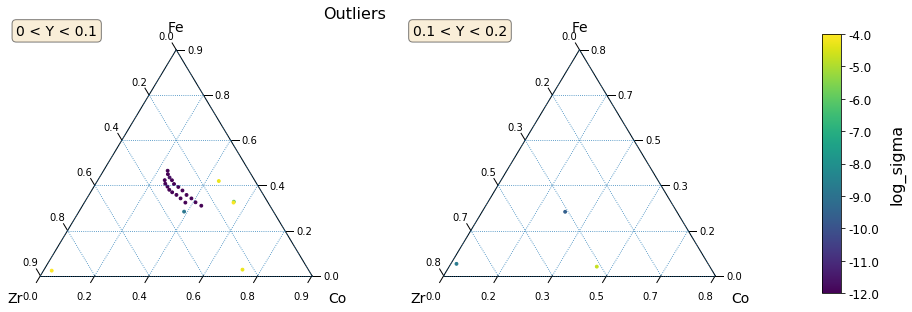

In [176]:
ax1 = dc.plot_inliers(**plot_args,vmin=-12,vmax=-4)
plt.gcf().suptitle('Inliers',x=0.4,size=16)
ax2 = dc.plot_outliers(**plot_args,vmin=-12,vmax=-4)
ax2[0].get_figure().suptitle('Outliers',x=0.4,size=16)

In [177]:
dc.remove_outliers()

,Point,Sigma_elec,T_set,Temp_C,atm,d_um,formula,sample,x_mm,y_mm,Ba,Co,Fe,Zr,Y,log_sigma
1_500C_dry_1251,1,0.000016,500C,437,dry,0.112290,Ba0.96661Co0.39251Fe0.47442Y0.0Zr0.13307O3,PDAC_COM3_01251,0,0.0,0.966610,0.392510,0.474420,0.133070,0.000000,-4.807415
2_500C_dry_1251,2,0.000015,500C,437,dry,0.114887,Ba0.96761Co0.39187Fe0.47506Y0.0Zr0.13306O3,PDAC_COM3_01251,0,1.5,0.967620,0.391874,0.475065,0.133061,0.000000,-4.810406
3_500C_dry_1251,3,0.000014,500C,437,dry,0.117484,Ba0.96861Co0.39123Fe0.47571Y0.0Zr0.13306O3,PDAC_COM3_01251,0,3.0,0.968610,0.391230,0.475710,0.133060,0.000000,-4.838679
4_500C_dry_1251,4,0.000014,500C,437,dry,0.119250,Ba0.96766Co0.41426Fe0.46485Y0.0Zr0.12089O3,PDAC_COM3_01251,-4,0.0,0.967660,0.414260,0.464850,0.120890,0.000000,-4.847826
5_500C_dry_1251,5,0.000016,500C,437,dry,0.122203,Ba0.96786Co0.41307Fe0.4645Y0.0Zr0.12244O3,PDAC_COM3_01251,-4,1.5,0.967850,0.413066,0.464495,0.122439,0.000000,-4.801500
6_500C_dry_1251,6,0.000016,500C,437,dry,0.125156,Ba0.96806Co0.41187Fe0.46415Y0.0Zr0.12398O3,PDAC_COM3_01251,-4,3.0,0.968060,0.411870,0.464150,0.123980,0.000000,-4.802546
7_500C_dry_1251,7,0.000015,500C,437,dry,0.125930,Ba0.96603Co0.42604Fe0.44199Y0.0Zr0.13197O3,PDAC_COM3_01251,-8,0.0,0.966030,0.426040,0.441990,0.131970,0.000000,-4.812311
8_500C_dry_1251,8,0.000016,500C,437,dry,0.129211,Ba0.96645Co0.426Fe0.44163Y0.0Zr0.13237O3,PDAC_COM3_01251,-8,1.5,0.966450,0.426000,0.441630,0.132370,0.000000,-4.797307
9_500C_dry_1251,9,0.000016,500C,437,dry,0.132492,Ba0.96686Co0.42596Fe0.44127Y0.0Zr0.13277O3,PDAC_COM3_01251,-8,3.0,0.966860,0.425960,0.441270,0.132770,0.000000,-4.783371
10_500C_dry_1251,10,0.000015,500C,437,dry,0.129340,Ba0.97058Co0.44908Fe0.43028Y0.0Zr0.12064O3,PDAC_COM3_01251,-12,0.0,0.970580,0.449080,0.430280,0.120640,0.000000,-4.835038


In [161]:
#dir(dc)
#dc.cluster_hist()
help(dc)


Help on DataCleaner in module helpers.outlier_detect object:

class DataCleaner(builtins.object)
 |  Class for outlier detection and data cleaning in preprocessing
 |  Implements sklearn.cluster.DBSCAN for compositional clustering, 
 |  and sklearn.ensemble.IsolationForest for greedy outlier flagging.
 |  Applies z-score threshold within composition clusters to screen 
 |  IsolationForest flags.
 |  
 |  Parameters
 |  ----------
 |  data: dataset to process (pandas DataFrame)
 |  prop_dim: property dimension to screen for outliers
 |  comp_dims: composition dimensions for clustering and IsolationForest
 |  DB_kw: kwargs to pass to DBSCAN instantiation
 |  IF_kw: kwargs to pass to IsolationForest instantiation
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, prop_dim, comp_dims=None, DB_kw={}, IF_kw={})
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cluster_hist(self, ncols=2)
 |  
 |  fit(self, comp_scale=1)
 |      fit DBSCAN and Isolation

# Featurize

In [178]:
df = dc.clean_data.loc[:,['sample','Point','formula','Sigma_elec','log_sigma']]

## Speed test

In [9]:
tdf = df.iloc[0:100,:]
pp = PerovskiteProperty.from_preset('BCFZY')
pp.set_featurize_options(sites=['comp','B'],ox_stats=['mean'])

In [10]:
t1 = time.time()
par_df = pp.featurize_dataframe(tdf,col_id="formula",inplace=False)
parallel_time = time.time() - t1

HBox(children=(IntProgress(value=0, description='PerovskiteProperty'), HTML(value='')))

In [11]:
pp.set_n_jobs(1)
t1 = time.time()
ser_df = pp.featurize_dataframe(tdf,col_id="formula",inplace=False)
series_time = time.time() - t1

HBox(children=(IntProgress(value=0, description='PerovskiteProperty'), HTML(value='')))

In [12]:
print('Parallel: Total time: {}, Time per record: {}'.format(parallel_time,parallel_time/len(tdf)))
print('Series: Total time: {}, Time per record: {}'.format(series_time,series_time/len(tdf)))

Parallel: Total time: 98.30126976966858, Time per record: 0.9830126976966858
Series: Total time: 366.43086528778076, Time per record: 3.6643086528778075


## Featurize full dataframe

In [10]:
pp = PerovskiteProperty.from_preset('BCFZY')
pp.set_featurize_options(sites=['comp','B'],ox_stats=['mean'])
pp.ElementProperty.stats = ['mean']
t1 = time.time()
feature_df = pp.featurize_dataframe(df,col_id='formula',inplace=False)
full_time = time.time() - t1
print('Full featurization time:\nTotal time: {}s\nTime per record: {}s'.format(full_time,full_time/len(df)))

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=503, style=ProgressStyle(description_width='initial')), HTML(value='')))


Full featurization time:
Total time: 548.8744597434998s
Time per record: 1.0912017092316098s


In [22]:
dt = feature_df.dtypes
dt[dt==np.dtype('O')]

sample                  object
formula                 object
comp_HOMO_character     object
comp_LUMO_character     object
Bsite_HOMO_character    object
Bsite_LUMO_character    object
dtype: object

In [77]:
list(feature_df.columns)

['sample',
 'Point',
 'formula',
 'Sigma_elec',
 'log_sigma',
 'comp_oxmean_goldschmidt',
 'comp_oxmean_goldschmidt_struct',
 'comp_oxmean_tau',
 'comp_oxmean_tot_cat_charge',
 'comp_oxmean_anion_delta',
 'comp_oxmean_alat_hardsphere',
 'comp_oxmean_uc_vol',
 'comp_oxmean_uc_vol_free',
 'comp_oxmean_r_crit',
 'comp_oxmean_r_mean',
 'comp_oxmean_r_std',
 'comp_oxmean_OS_mean',
 'comp_oxmean_OS_std',
 'comp_oxmean_tot_charge',
 'comp_oxmean_X_cat_mean',
 'comp_oxmean_X_cat_std',
 'comp_oxmean_ion_energy_mean',
 'comp_oxmean_ion_energy_std',
 'Bsite_oxmean_r_mean',
 'Bsite_oxmean_r_std',
 'Bsite_oxmean_OS_mean',
 'Bsite_oxmean_OS_std',
 'Bsite_oxmean_tot_charge',
 'Bsite_oxmean_X_cat_mean',
 'Bsite_oxmean_X_cat_std',
 'Bsite_oxmean_ion_energy_mean',
 'Bsite_oxmean_ion_energy_std',
 'comp_oxmean_H_formation',
 'comp_oxmean_MX_ABE',
 'Bsite_oxmean_MX_ABE',
 'comp_num_atoms',
 'comp_X_mean',
 'comp_X_std',
 'comp_TM_frac',
 'comp_multivalent_frac',
 'comp_net_alio_mag',
 'comp_acceptor_mag',

# Pair plots for correlations

<IPython.core.display.Javascript object>


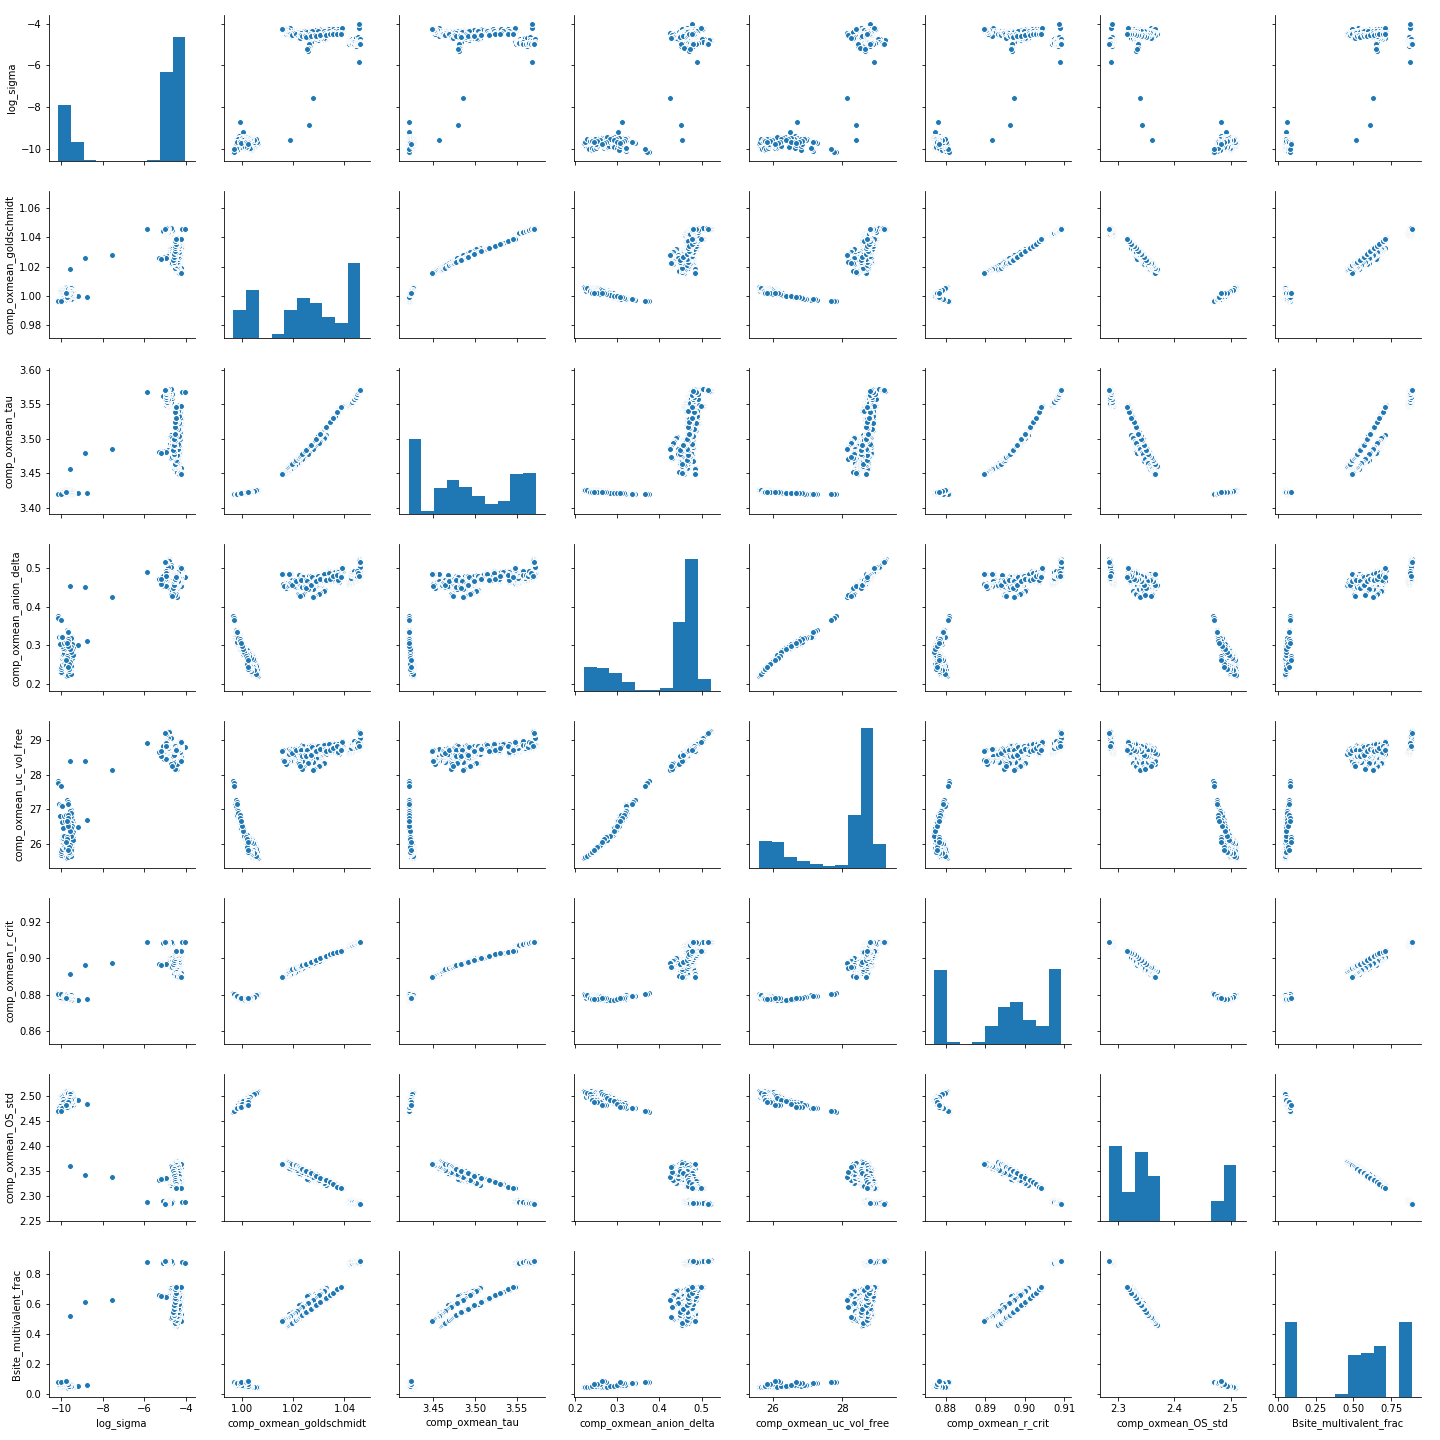

In [168]:
#sns.pairplot(feature_df.loc[:,'log_sigma':'comp_oxmean_anion_delta'])
pairfeat = ['log_sigma','comp_oxmean_goldschmidt','comp_oxmean_tau','comp_oxmean_anion_delta','comp_oxmean_uc_vol_free',
            'comp_oxmean_r_crit','comp_oxmean_OS_std','Bsite_multivalent_frac']
sns.pairplot(feature_df.loc[:,pairfeat])

In [42]:
"Calculate pearson and distance correlation matrices"
dt = feature_df.dtypes
nonnumeric = list(dt[dt==np.dtype('O')].index)
drop = [nn for nn in nonnumeric if nn not in ['sample', 'formula']] 
drop
X = feature_df.loc[:,'log_sigma':].drop(drop,axis=1).values
X_df = feature_df.loc[:,'log_sigma':].drop(drop,axis=1)
corr = np.corrcoef(X,rowvar=False)
dcorr = distcorr_array(X)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:34: RuntimeWarning:

invalid value encountered in double_scalars



<IPython.core.display.Javascript object>


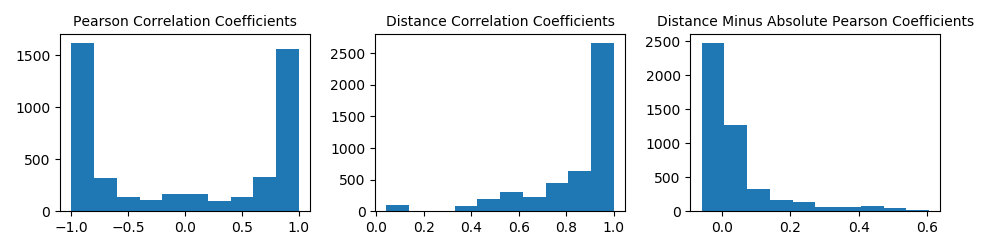

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



In [45]:
%matplotlib notebook
"Compare distributions of correlation coefficients"
#get indices for lower triangle of array (below main diagonal)
tri = np.tril_indices(len(corr),k=-1)
#get coefficients from lower triangle to exclude duplicates (correlation matrices are symmetric)
corr_flat = corr[tri]
dcorr_flat = dcorr[tri]

fig, axes = plt.subplots(1,3,figsize=(10,2.5))
axes[0].hist(corr_flat)
axes[0].set_title('Pearson Correlation Coefficients',size=10)
axes[1].hist(dcorr_flat)
axes[1].set_title('Distance Correlation Coefficients',size=10)
corr_diff = dcorr_flat - np.abs(corr_flat)
axes[2].hist(corr_diff)
axes[2].set_title('Distance Minus Absolute Pearson Coefficients',size=10)
fig.tight_layout()

## Correlation groups

In [46]:
#get pairs of columns that are highly correlated
#only consider upper triangle to exclude self-correlation and duplicate correlations (matrix is symmetric)
hi_corr = np.where(np.abs(np.triu(corr,1))>=0.999)
hi_corr

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in greater_equal



(array([  1,   4,   4,   4,   5,   5,   6,  11,  12,  13,  13,  13,  13,
         21,  21,  21,  23,  23,  28,  29,  29,  29,  30,  31,  31,  31,
         31,  34,  34,  34,  35,  35,  35,  35,  35,  36,  36,  36,  37,
         37,  39,  42,  42,  42,  42,  42,  45,  45,  45,  46,  49,  49,
         49,  51,  53,  53,  55,  56,  56,  56,  56,  56,  56,  56,  56,
         56,  56,  58,  59,  59,  59,  59,  59,  59,  60,  60,  60,  62,
         62,  63,  66,  66,  66,  67,  76,  79,  79,  79,  82,  82,  82,
         82,  82,  85,  85,  85,  85,  85,  88,  88,  88,  88,  90,  94,
         94,  94,  95,  98,  98,  99, 103, 104, 104, 109, 114], dtype=int64),
 array([ 19,   5,  12,  14,  12,  14,   7,  76,  14,  21,  23,  67,  98,
         23,  67,  98,  67,  98,  58,  30,  59,  60,  60,  34,  53,  55,
         81,  53,  55,  81,  42,  45,  49, 103, 105,  37,  46,  47,  46,
         47,  73,  45,  51,  82, 103, 116,  49, 103, 105,  47, 102, 103,
        105, 116,  55,  81,  81,  59,  60,  62

In [438]:
def get_linked_groups(corrcoeff, thresh):
    """
    Get groups of directly and indirectly correlated columns
    
    Args:
        corrcoeff: correlation coefficient matrix
        thresh: correlation coefficient threshold for linking
    """
    correlated_columns = np.where(np.abs(np.triu(np.nan_to_num(corrcoeff,0),1))>=thresh)
    
#     corr_nodiag = corrcoeff - np.diag(np.diag(corrcoeff))
#     correlated_columns = np.where(np.abs(np.nan_to_num(corr_nodiag,0))>=thresh)
    
    groups = []
    for num in np.unique(correlated_columns[0]):
        in_set = [num in numset for numset in groups]
        if max(in_set,default=False)==False:
            #if not already in a set, get correlated var nums and check if they belong to an existing set
            cnums = correlated_columns[1][np.where(correlated_columns[0]==num)]
            numset = set([num] + list(cnums))
            #check if numset intersects an existing set
            intersect = [numset & group for group in groups]
            if len(intersect) > 0:
                intersect_group = intersect[np.argmax(intersect)]
            else:
                intersect_group = []
            #if intersects existing set, add to set
            if len(intersect_group) > 0:
                intersect_group |= numset
                #print('case 1 existing group:', num, intersect_group)
            #otherwise, make new set
            else:
                groups.append(numset)
                #print('new group:', num, cnums)
        else:
            #if already in a set, get correlated var nums and add to set
            group = groups[in_set.index(True)]
            cnums = correlated_columns[1][np.where(correlated_columns[0]==num)]
            group |= set(cnums) #union
            #print('case 2 existing group:', num, group)
    
    #some links may not be captured. Ex: 1 -> {4,5}. 2 -> 3. 3 -> 4. Now groups are: {1,4,5}, {2,3,4} - need to combine
    #safety net - combine groups that share common elements
    for i,group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            if len(group1 & group2) > 0:
                group1 |= group2
                groups.remove(group2)
    
    return groups


# groups = get_linked_groups(corr,0.999)
# groups

<IPython.core.display.Javascript object>


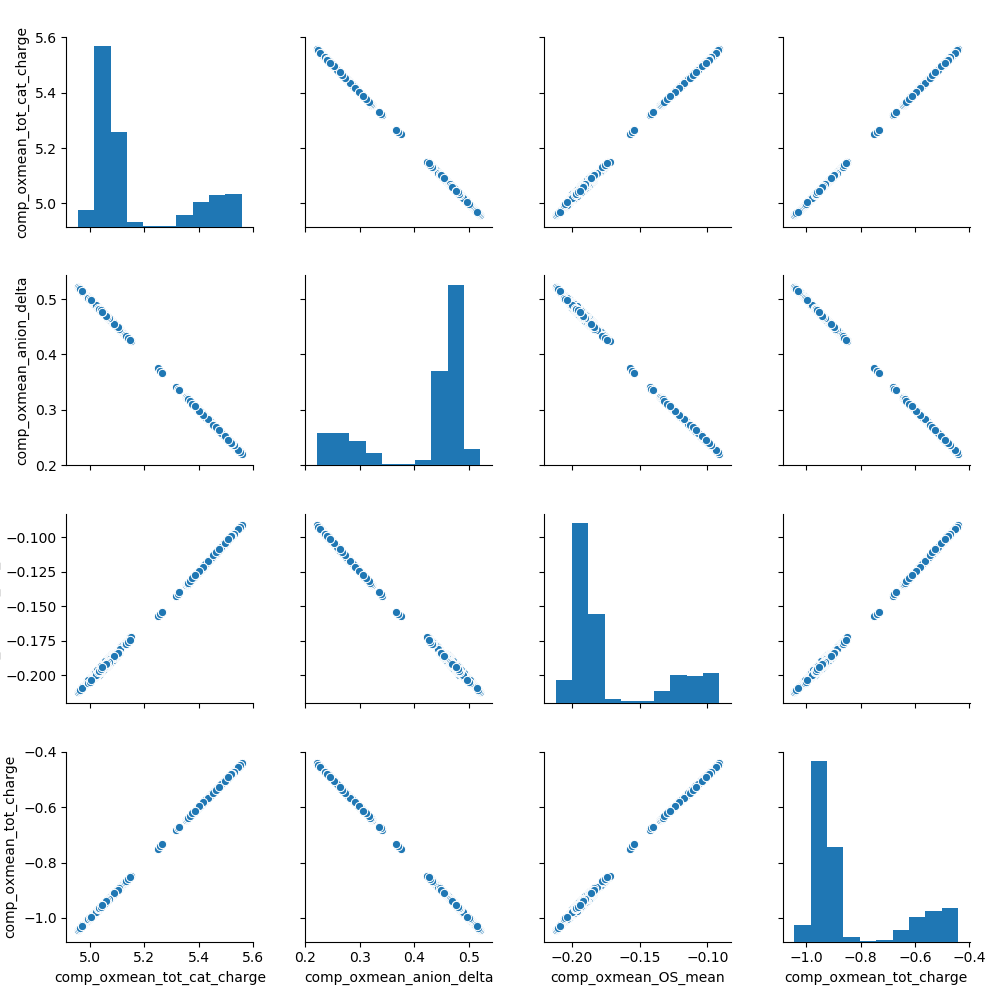

In [29]:
# for cor_group in groups:
#     grp_df = X_df.iloc[:,list(cor_group)]
#     sns.pairplot(grp_df)
group_num = 1
grp_df = X_df.iloc[:,list(groups[group_num])]
sns.pairplot(grp_df)

In [158]:
len(np.unique(hi_corr))

14

In [271]:
X_df.columns[list(groups[0])]

Index(['comp_oxmean_goldschmidt', 'comp_oxmean_r_crit', 'comp_oxmean_r_std',
       'Bsite_oxmean_r_mean', 'Bsite_X_mean', 'Bsite_multivalent_frac',
       'Bsite_mass_mean', 'Bsite_MX_IC_mean', 'comp_valence_elec_d_mean',
       'comp_valence_elec_s_frac', 'comp_valence_elec_p_frac',
       'comp_valence_elec_d_frac', 'comp_valence_elec_tot_mean',
       'comp_cohesive_energy_mean', 'comp_boil_temp_mean', 'comp_column_mean',
       'comp_density_mean', 'comp_molar_vol_mean', 'comp_H_vap_mean',
       'comp_valence_unfilled_d_mean', 'comp_polarizability_mean',
       'comp_sigma_therm_mean', 'Bsite_valence_elec_d_mean',
       'Bsite_valence_elec_s_frac', 'Bsite_valence_elec_d_frac',
       'Bsite_valence_elec_tot_mean', 'Bsite_cohesive_energy_mean',
       'Bsite_boil_temp_mean', 'Bsite_melt_temp_mean', 'Bsite_shear_mod_mean',
       'Bsite_row_mean', 'Bsite_column_mean', 'Bsite_number_mean',
       'Bsite_mendeleev_mean', 'Bsite_density_mean', 'Bsite_molar_vol_mean',
       'Bsite_H_

## log_sigma correlations

In [179]:
pp.set_featurize_options(sites=['comp','B'],ox_stats=['min','max','mean','std','range'])
pp.ElementProperty.stats = ["mean", "std_dev", "range"]
t1 = time.time()
fullfeature_df = pp.featurize_dataframe(df,col_id='formula',inplace=False)
full_time = time.time() - t1
print('Full featurization time:\nTotal time: {}s\nTime per record: {}s'.format(full_time,full_time/len(df)))

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=496, style=ProgressStyle(description_width='initial')), HTML(value='')))


Full featurization time:
Total time: 489.02452993392944s
Time per record: 0.9859365522861481s


In [263]:
"Calculate pearson and distance correlation matrices"
fdt = fullfeature_df.dtypes
fnonnumeric = list(fdt[fdt==np.dtype('O')].index)
drop = [nn for nn in fnonnumeric if nn not in ['sample', 'formula']] 
drop
fX = fullfeature_df.loc[:,'log_sigma':].drop(drop,axis=1).values
fX_df = fullfeature_df.loc[:,'log_sigma':].drop(drop,axis=1)
fcorr = np.corrcoef(fX,rowvar=False)
fdcorr = distcorr_array(fX)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:37: RuntimeWarning:

invalid value encountered in double_scalars



C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



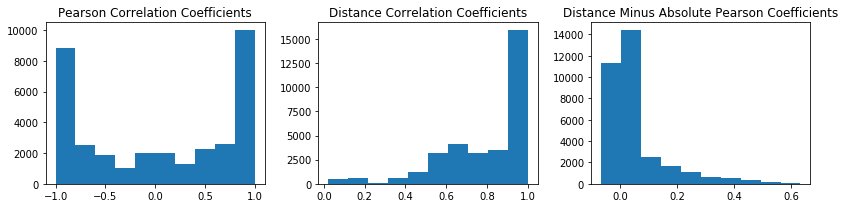

In [264]:
"Compare distributions of correlation coefficients"
#get indices for lower triangle of array (below main diagonal)
tri = np.tril_indices(len(fcorr),k=-1)
#get coefficients from lower triangle to exclude duplicates (correlation matrices are symmetric)
fcorr_flat = fcorr[tri]
fdcorr_flat = fdcorr[tri]

fig, axes = plt.subplots(1,3,figsize=(12,3))
axes[0].hist(fcorr_flat)
axes[0].set_title('Pearson Correlation Coefficients')
axes[1].hist(fdcorr_flat)
axes[1].set_title('Distance Correlation Coefficients')
fcorr_diff = fdcorr_flat - np.abs(fcorr_flat)
axes[2].hist(fcorr_diff)
axes[2].set_title('Distance Minus Absolute Pearson Coefficients')
fig.tight_layout()

In [256]:
fcorr.shape,fullfeature_df.shape

((314, 314), (496, 322))

In [274]:
hi_fcorr = np.where(np.abs(np.triu(fcorr,1))>=1)#0.999)
groups = get_linked_groups(hi_fcorr)
groups

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in greater_equal



[{22, 23},
 {31, 77, 120, 122},
 {40, 41, 86, 131},
 {84, 155},
 {102, 166, 167},
 {139, 149},
 {156, 157},
 {189, 192, 216, 219, 222, 243},
 {234, 274, 280, 304, 310, 313},
 {246, 252, 302},
 {248, 250},
 {253, 254},
 {273, 303},
 {289, 292, 313}]

In [273]:
fX_df.columns[list(groups[13])]

Index(['Bsite_cohesive_energy_mean', 'Bsite_oxrange_OS_mean',
       'Bsite_boil_temp_mean', 'Bsite_oxrange_tot_charge',
       'Bsite_oxrange_X_cat_mean', 'Bsite_oxrange_ion_energy_mean',
       'Bsite_shear_mod_mean', 'Bsite_row_mean', 'comp_oxmin_MX_ABE',
       'comp_oxmean_MX_ABE', 'Bsite_column_mean', 'comp_oxmax_MX_ABE',
       'Bsite_oxmin_MX_ABE', 'Bsite_number_mean', 'Bsite_oxmax_MX_ABE',
       'Bsite_oxmean_MX_ABE', 'comp_multivalent_frac', 'Bsite_X_mean',
       'comp_oxrange_goldschmidt', 'Bsite_multivalent_frac',
       'Bsite_H_vap_mean', 'comp_oxrange_tot_cat_charge',
       'comp_oxrange_anion_delta', 'Bsite_mass_mean', 'Bsite_MX_IC_mean',
       'Bsite_valence_unfilled_d_mean', 'comp_valence_elec_d_mean',
       'comp_oxmin_OS_std', 'comp_valence_elec_p_frac',
       'Bsite_polarizability_mean', 'comp_valence_elec_d_frac',
       'comp_valence_elec_tot_mean', 'Bsite_sigma_therm_mean',
       'comp_cohesive_energy_mean', 'comp_boil_temp_mean',
       'comp_boil_temp_s

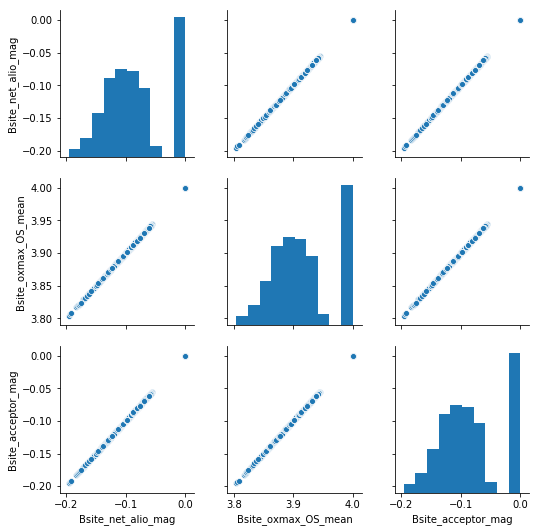

In [289]:
group_num = 4
grp_df = fX_df.iloc[:,list(groups[group_num])]
sns.pairplot(grp_df)

In [62]:
fX_df.columns[sort_idx[:10]]

Index(['log_sigma', 'comp_LUMO_energy', 'comp_HOMO_energy',
       'Bsite_oxmax_r_std', 'Bsite_oxmean_ion_energy_mean',
       'Bsite_oxmax_OS_std', 'comp_oxmean_tot_charge',
       'comp_oxmean_anion_delta', 'comp_oxmean_tot_cat_charge',
       'comp_number_std'],
      dtype='object')

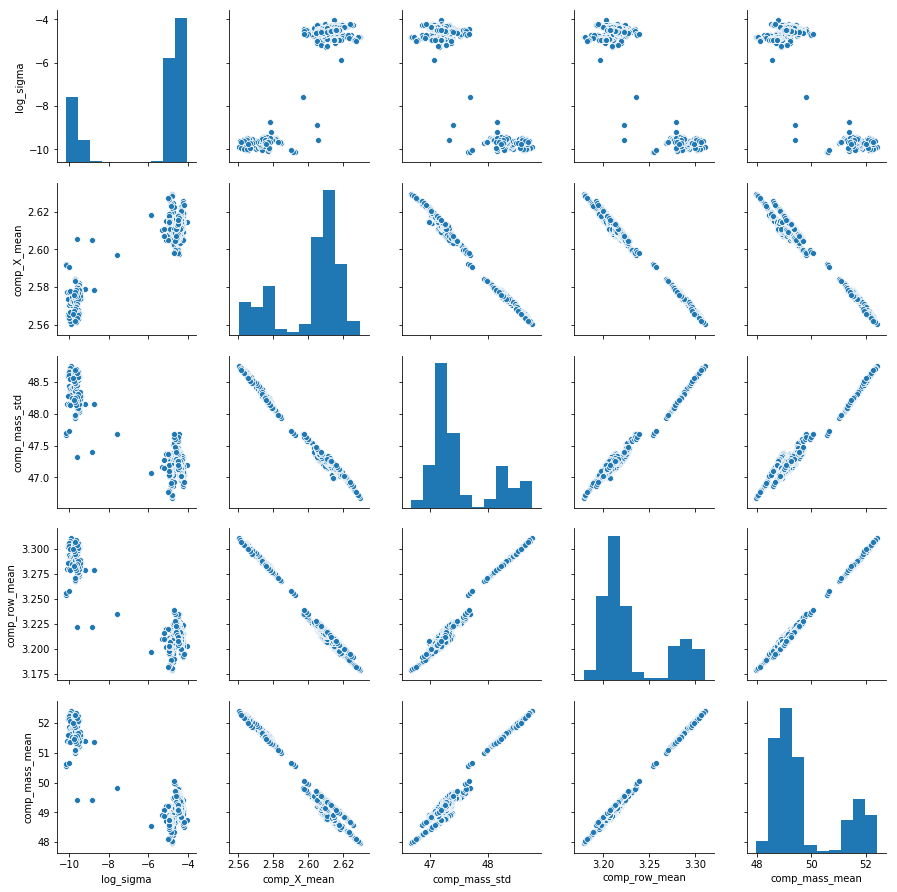

In [259]:
%matplotlib inline
sns.pairplot(fX_df,vars=fX_df.columns[sort_idx[:5]])
plt.savefig('plots/190225_logSigmaCorrelations.png',dpi=500)

In [15]:
fullfeature_df.head()

,sample,Point,formula,Sigma_elec,log_sigma,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,...,Bsite_valence_unfilled_d_range,Bsite_valence_unfilled_f_mean,Bsite_valence_unfilled_f_std,Bsite_valence_unfilled_f_range,Bsite_polarizability_mean,Bsite_polarizability_std,Bsite_polarizability_range,Bsite_sigma_therm_mean,Bsite_sigma_therm_std,Bsite_sigma_therm_range
1_500C_dry_1251,PDAC_COM3_01251,1,Ba0.96661Co0.39251Fe0.47442Y0.0Zr0.13307O3,0.000016,-4.807415,0.992770,2.0,3.420198,4.199360,0.03339,...,5.0,0.0,0.0,0.0,9.310906,4.366087,10.4,80.265210,31.256912,77.0
2_500C_dry_1251,PDAC_COM3_01251,2,Ba0.96761Co0.39187Fe0.47506Y0.0Zr0.13306O3,0.000015,-4.810406,0.992760,2.0,3.420200,4.201362,0.03238,...,5.0,0.0,0.0,0.0,9.311396,4.366072,10.4,80.252983,31.252458,77.0
3_500C_dry_1251,PDAC_COM3_01251,3,Ba0.96861Co0.39123Fe0.47571Y0.0Zr0.13306O3,0.000014,-4.838679,0.992749,2.0,3.420202,4.203340,0.03139,...,5.0,0.0,0.0,0.0,9.311963,4.366148,10.4,80.240180,31.248498,77.0
4_500C_dry_1251,PDAC_COM3_01251,4,Ba0.96766Co0.41426Fe0.46485Y0.0Zr0.12089O3,0.000014,-4.847826,0.992785,2.0,3.420195,4.177100,0.03234,...,5.0,0.0,0.0,0.0,9.175621,4.220080,10.4,81.394470,30.514564,77.0
5_500C_dry_1251,PDAC_COM3_01251,5,Ba0.96786Co0.41307Fe0.4645Y0.0Zr0.12244O3,0.000016,-4.801500,0.992809,2.0,3.420190,4.180578,0.03215,...,5.0,0.0,0.0,0.0,9.191409,4.239298,10.4,81.282307,30.623274,77.0


In [23]:
#get correlations for each sample
sample_dcorr = {}
for grpname, grpdf in fullfeature_df.groupby('sample'):
    X_tmp = grpdf.loc[:,'log_sigma':].drop(drop,axis=1).values
    sample_dcorr[grpname] = distcorr_array(X_tmp)

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:37: RuntimeWarning:

invalid value encountered in double_scalars



In [71]:
#get features most correlated with log_sigma for each sample
top_cols = {}
for sample, dcm in sample_dcorr.items():
    sort_idx = np.argsort(np.nan_to_num(dcm[0],0))[::-1]
    sorted_corr = dcm[0][sort_idx]
    cols = fX_df.columns[sort_idx[1:]] #first column is always log_sigma itself (self-correlation)
    #top_col = dict(zip(cols[:5],sorted_corr[:5]))
    top_cols[sample] = list(cols[:5])
   

<IPython.core.display.Javascript object>


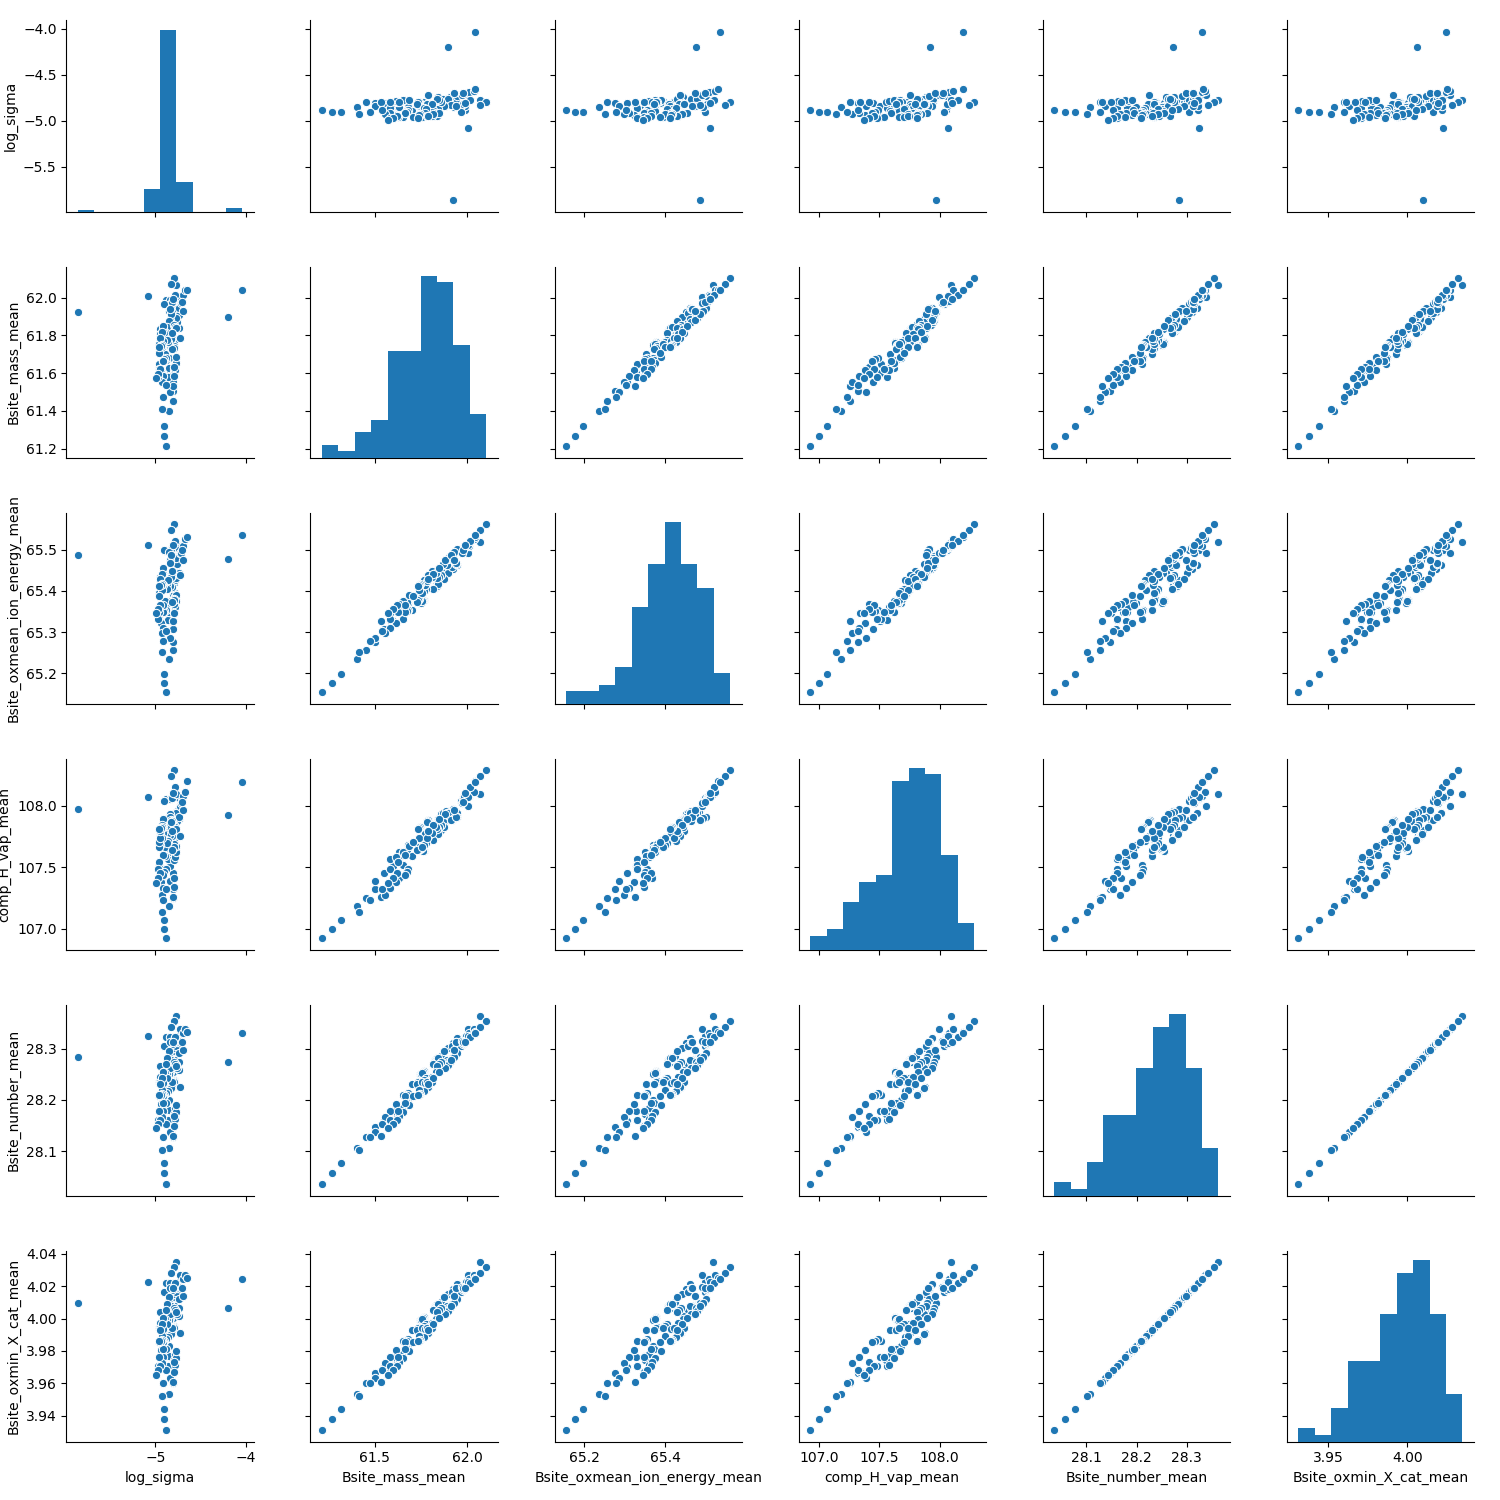

In [74]:
"plot most correlated features"
for sample, cols in list(top_cols.items())[0:1]:#top_cols.items():
    tdf = fullfeature_df.groupby('sample').get_group(sample)
    sns.pairplot(tdf,vars=['log_sigma'] + cols)
    
"note that all of top 5 features are correlated with each other - not very useful"

## Modeling

In [180]:
"Set up inputs"
drop = ['sample', 'Point', 'formula', 'Sigma_elec', 'log_sigma'] 

powers = [-3,-2,-1,-1/2,1/2,1,2,3]

#all feature columns
X_df = fullfeature_df.drop(drop,axis=1).dropna(axis=1)
X = X_df.values

#numeric columns only 
fdt = fullfeature_df.dtypes
drop += list(fdt[fdt==np.dtype('O')].index)
X_num_df = fullfeature_df.drop(drop,axis=1).dropna(axis=1)
X_num = X_num_df.values
X_num_poly = mv.poly_transform(X_num,powers,add_exp=False)

#response
y = fullfeature_df['log_sigma'].values

#cluster labels
clusters = fullfeature_df['sample'].values

..\helpers\model_eval.py:147: RuntimeWarning:

divide by zero encountered in power



Transformed matrix is clean


In [181]:
X_df.head()

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,...,Bsite_valence_unfilled_d_range,Bsite_valence_unfilled_f_mean,Bsite_valence_unfilled_f_std,Bsite_valence_unfilled_f_range,Bsite_polarizability_mean,Bsite_polarizability_std,Bsite_polarizability_range,Bsite_sigma_therm_mean,Bsite_sigma_therm_std,Bsite_sigma_therm_range
1_500C_dry_1251,0.992770,2.0,3.420198,4.199360,0.03339,4.186072,73.353379,24.475398,0.886408,1.083702,...,5.0,0.0,0.0,0.0,9.310906,4.366087,10.4,80.265210,31.256912,77.0
2_500C_dry_1251,0.992760,2.0,3.420200,4.201362,0.03238,4.186072,73.353379,24.464849,0.886424,1.083683,...,5.0,0.0,0.0,0.0,9.311396,4.366072,10.4,80.252983,31.252458,77.0
3_500C_dry_1251,0.992749,2.0,3.420202,4.203340,0.03139,4.186072,73.353379,24.454493,0.886440,1.083663,...,5.0,0.0,0.0,0.0,9.311963,4.366148,10.4,80.240180,31.248498,77.0
4_500C_dry_1251,0.992785,2.0,3.420195,4.177100,0.03234,4.186072,73.353379,24.476583,0.886387,1.085298,...,5.0,0.0,0.0,0.0,9.175621,4.220080,10.4,81.394470,30.514564,77.0
5_500C_dry_1251,0.992809,2.0,3.420190,4.180578,0.03215,4.186072,73.353379,24.473465,0.886352,1.085143,...,5.0,0.0,0.0,0.0,9.191409,4.239298,10.4,81.282307,30.623274,77.0


### Clustered K-fold CV

In [235]:
"Elastic net"
interact_manual(
    mv.plot_clustered_cv,
    estimator_class = fixed(ElasticNet),
    X=fixed(X_num_poly),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random'],
    ncol = fixed(4)
)
#best results:
#l1_ratio=0: alpha = 0.00215, avg test score = 0.318
#l1_ratio=0.5: alpha = 0.0059948, avg test score = 0.3376
#l1_ratio=0.9: alpha = 0.00215, avg test score = 0.3345

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_clustered_cv>

In [238]:
"Random forest"
interact_manual(
    mv.plot_clustered_cv,
    estimator_class = fixed(RandomForestRegressor),
    X=fixed(X_num),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,3,4,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False],
    ncol = fixed(4)
        );

#n_est=25,max_feat=5,max_depth=5,leaf=2,split=5 - mean test score=0.40-0.47

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [239]:
"Kernel ridge"
interact_manual(
    mv.plot_clustered_cv,
    estimator_class = fixed(KernelRidge),
    X = fixed(X_num),
    y = fixed(y),
    clusters = fixed(clusters),
    alpha = np.logspace(-5,2,20),
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10),
    ncol = fixed(4)
)
#poly, deg 3, alpha=0.0207, avg test score = 0.341
#laplacian, alpha=0.0483, avg test score = 0.3362

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(1e-05, 2.3357214690901213e-05, 5.4555947811685143e-05, 0.00012742749857031334, 0.00029763514416313193, 0.0006951927961775605, 0.001623776739188721, 0.00379269019073225, 0.008858667904100823, 0.02069138081114788, 0.04832930238571752, 0.11288378916846883, 0.26366508987303555, 0.6158482110660255, 1.438449888287663, 3.359818286283781, 7.847599703514606, 18.32980710832434, 42.81332398719387, 100.0), value=1e-05), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_clustered_cv>

In [243]:
"SVR"
interact_manual(
    mv.plot_clustered_cv,
    estimator_class = fixed(SVR),
    X = fixed(X_num),
    y = fixed(y),
    clusters = fixed(clusters),
    C = np.logspace(-3,4,20),
    epsilon = [0.01,0.05,0.1,0.2,0.5],
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10),
    ncol = fixed(4)
)
#poly, deg 2, C=61.58, eps=0.05, avg test score = 0.432
#linear, C=61.58, eps=0.05, avg test score = 0.420

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='C', options=(0.001, 0.002335721469090121, 0.00545559478116852, 0.012742749857031334, 0.029763514416313176, 0.06951927961775606, 0.1623776739188721, 0.37926901907322497, 0.8858667904100823, 2.069138081114788, 4.832930238571752, 11.288378916846883, 26.366508987303554, 61.58482110660255, 143.8449888287663, 335.9818286283781, 784.7599703514607, 1832.9807108324337, 4281.332398719387, 10000.0), value=0.001), Dropdown(description='epsilon', options=(0.01, 0.05, 0.1, 0.2, 0.5), value=0.01), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_clustered_cv>

### LOCO-CV

In [248]:
"Elastic net"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(ElasticNet),
    X=fixed(X_num_poly),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random'],
    ncol = fixed(4)        
)

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

In [249]:
"Random forest"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(RandomForestRegressor),
    X=fixed(X_num),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False],
    ncol = fixed(4)
        );

#gets cluster means right: 50 estimators, None max_feat and max_depth, leaf=2, split=5

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [246]:
"Kernel ridge"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(KernelRidge),
    X = fixed(X_num),
    y = fixed(y),
    clusters = fixed(clusters),
    alpha = np.logspace(-5,2,20),
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10),
    ncol = fixed(4)
)

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(1e-05, 2.3357214690901213e-05, 5.4555947811685143e-05, 0.00012742749857031334, 0.00029763514416313193, 0.0006951927961775605, 0.001623776739188721, 0.00379269019073225, 0.008858667904100823, 0.02069138081114788, 0.04832930238571752, 0.11288378916846883, 0.26366508987303555, 0.6158482110660255, 1.438449888287663, 3.359818286283781, 7.847599703514606, 18.32980710832434, 42.81332398719387, 100.0), value=1e-05), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

In [247]:
"SVR"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(SVR),
    X = fixed(X_num),
    y = fixed(y),
    clusters = fixed(clusters),
    C = np.logspace(-5,2,20),
    epsilon = [0.01,0.05,0.1,0.2,0.5],
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10),
    ncol = fixed(4)
)

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='C', options=(1e-05, 2.3357214690901213e-05, 5.4555947811685143e-05, 0.00012742749857031334, 0.00029763514416313193, 0.0006951927961775605, 0.001623776739188721, 0.00379269019073225, 0.008858667904100823, 0.02069138081114788, 0.04832930238571752, 0.11288378916846883, 0.26366508987303555, 0.6158482110660255, 1.438449888287663, 3.359818286283781, 7.847599703514606, 18.32980710832434, 42.81332398719387, 100.0), value=1e-05), Dropdown(description='epsilon', options=(0.01, 0.05, 0.1, 0.2, 0.5), value=0.01), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

### Elastic Net feature select

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



18 non-zero coefficients
Avg non-zero coefficent magnitude: 0.02707683619154644
58 non-zero coefficients
Avg non-zero coefficent magnitude: 0.31003496604519953
71 non-zero coefficients
Avg non-zero coefficent magnitude: 0.057370056250265575
21 non-zero coefficients
Avg non-zero coefficent magnitude: 0.08873788971661345
96 non-zero coefficients
Avg non-zero coefficent magnitude: 0.04274308426841025
Train scores:  [0.17390977 0.40471435 0.62084863 0.80132007 0.99453297] 
	Mean:  0.599065158725374
Test scores:  [0.13488518 0.373577   0.30341797 0.76671155 0.99368338] 
	Mean:  0.5144550180581507


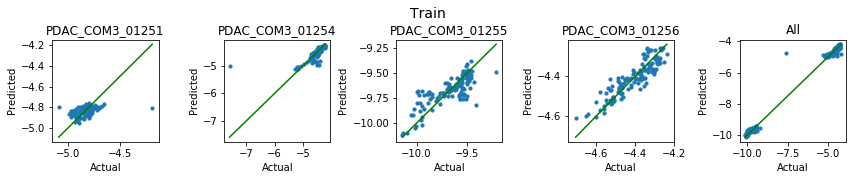

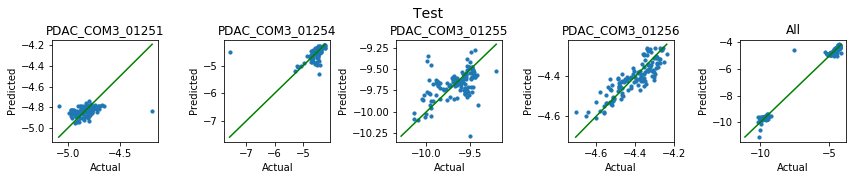

In [206]:
#train separate model for each cluster and compare weights

unique_clusters = list(np.unique(clusters))


train_scores = np.empty(len(unique_clusters)+1)
test_scores = np.empty(len(unique_clusters)+1)
coefs = np.empty((len(unique_clusters)+1,X_num_poly.shape[1]))


#axes for train pva plots
fig1, axes1 = plt.subplots(1,5,figsize=(12,2.5))
#axes for test pva plots
fig2, axes2 = plt.subplots(1,5,figsize=(12,2.5))

ss = StandardScaler()
Xt = ss.fit_transform(X_num_poly)



for i, (cluster,ax1,ax2) in enumerate(zip(unique_clusters+['All'],axes1,axes2)):
    #train a linear model for each cluster
    if cluster =='All':
        Xtc = Xt
        yc = y
        lr = ElasticNet(alpha=0.001,l1_ratio=0.9,max_iter=5000)
    else:
        cidx = np.where(clusters==cluster)
        Xtc = Xt[cidx]
        yc = y[cidx]
        lr = ElasticNet(alpha=0.0002,l1_ratio=0.9,max_iter=5000)
    
    lr.fit(Xtc,yc)
    train_scores[i] = lr.score(Xtc,yc)
    coefs[i] = lr.coef_
    #print('Avg coef: ',np.mean(np.abs(lr.coef_)))
    print("{} non-zero coefficients".format(len(lr.coef_[lr.coef_ != 0])))
    print("Avg non-zero coefficent magnitude: {}".format(np.mean(np.abs((lr.coef_[lr.coef_ != 0])))))
    
    #plot training data
    ax1.set_title(cluster)
    plot_pva(Xtc,yc,lr,ax=ax1,logscale=False)
    
    #plot test data
    ax2.set_title(cluster)
    score = mv.KFold_pva(lr,Xtc,yc,k=4,ax=ax2,logscale=False)
    test_scores[i] = np.mean(score)
    
    #print(lr.intercept_)
    
fig1.suptitle('Train',size=14)
fig2.suptitle('Test',size=14)
fig1.tight_layout()  
fig2.tight_layout()
fig1.subplots_adjust(top=0.8)
fig2.subplots_adjust(top=0.8)

print("Train scores: ",train_scores,'\n\tMean: ', np.mean(train_scores))
print("Test scores: ",test_scores,'\n\tMean: ', np.mean(test_scores))

In [207]:
#identify transformed and base features with non-zero coefficients
nonzeros = []
nonzeros_base = []
for coef in coefs:
    nonzeros.append(np.where(coef!=0))
    #get base variable
    nonzeros_base.append(np.unique((np.where(coef!=0)[0]/len(powers)).astype(int)))
nonzeros, nonzeros_base

([(array([  32,   33,   71,  424,  448,  449,  464,  465,  551, 1280, 1281,
          1282, 1283, 1284, 1285, 1286, 1287, 2008], dtype=int64),),
  (array([   0,    1,    2,    3,    4,    5,   56,   57,   68,   69,   70,
            71,  112,  113,  114,  120,  121,  177,  178,  183,  263,  271,
           279,  335,  343,  520,  521,  522,  523,  527,  537,  538,  639,
           823,  935, 1111, 1119, 1191, 1199, 1247, 1255, 1280, 1281, 1282,
          1283, 1285, 1286, 1287, 1327, 1335, 1456, 1464, 1975, 1983, 2014,
          2015, 2181, 2182], dtype=int64),),
  (array([  16,   17,   18,   19,   20,   21,   22,   23,   39,   40,   41,
            42,   43,   44,   45,   46,   47,   53,   54,   55,   80,   81,
            82,   83,   84,   85,   86,   87,  152,  176,  184,  185,  192,
           229,  231,  232,  233,  234,  256,  257,  264,  271,  272,  274,
           280,  304,  312,  320,  329,  332,  340,  344,  352,  353,  354,
           455,  520,  616,  704,  984, 1000, 1247

In [215]:
def common_elements(arrays,min_count):
    concat = np.concatenate(arrays)
    counter = dict(collections.Counter(np.concatenate(nonzeros_base)))
    
    return [k for k,v in counter.items() if v>=min_count]
            
#get base features that appear in models for at least 3/5 clusters    
base_features = X_num_df.columns.values
top_features = base_features[common_elements(nonzeros_base,3)]
top_features

array(['comp_oxmin_anion_delta', 'comp_oxmin_r_crit',
       'comp_oxmax_OS_mean', 'comp_oxmax_tot_charge',
       'comp_oxmean_X_cat_mean', 'Bsite_num_atoms',
       'comp_oxstd_alat_hardsphere', 'comp_oxstd_uc_vol',
       'comp_oxrange_alat_hardsphere', 'comp_oxrange_uc_vol',
       'comp_net_alio_mag', 'comp_acceptor_mag', 'Bsite_HOMO_energy',
       'Bsite_LUMO_energy', 'Bsite_space_group_std'], dtype=object)

In [314]:
fullfeature_df.shape

(496, 322)

In [300]:
top_corr = np.corrcoef(X_top_df.values,rowvar=False)
hi_topcorr = np.where(np.abs(np.triu(top_corr,1))>=0.98)
tgroups = get_linked_groups(hi_topcorr)
tgroups

[{0, 2, 3}, {6, 7, 8, 9}, {10, 11}, {12, 13}]

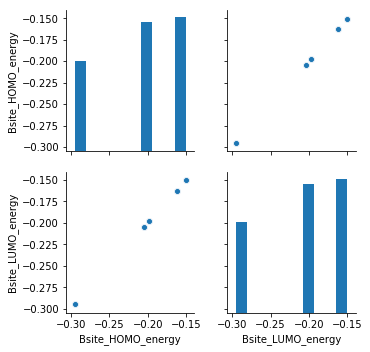

In [308]:
group_num = 3
sns.pairplot(X_top_df.iloc[:,list(tgroups[group_num])])
#sns.pairplot(fullfeature_df,vars=top_features)

In [313]:
allidx = set(np.arange(15))
hi = set(np.unique(hi_topcorr))
uncorr = list(allidx-hi)
X_top_df.columns[uncorr]

Index(['comp_oxmin_r_crit', 'comp_oxmean_X_cat_mean', 'Bsite_num_atoms',
       'Bsite_space_group_std'],
      dtype='object')

In [251]:
"Elastic net"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(ElasticNet),
    X=fixed(X_top_poly),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random'],
    ncol = fixed(4)        
)
#l1_ratio=0.5, alpha=0.00215 - cluster means look ok

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

In [232]:
"Random forest"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(RandomForestRegressor),
    X=fixed(X_top),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False],
    ncol = fixed(4)
        );

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [234]:
"Kernel ridge"
interact_manual(
    mv.plot_loco_cv,
    estimator_class = fixed(KernelRidge),
    X = fixed(X_top),
    y = fixed(y),
    clusters = fixed(clusters),
    alpha = np.logspace(-5,2,20),
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10),
    ncol = fixed(4)
)

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), Dropdown(description='alpha', options=(1e-05, 2.3357214690901213e-05, 5.4555947811685143e-05, 0.00012742749857031334, 0.00029763514416313193, 0.0006951927961775605, 0.001623776739188721, 0.00379269019073225, 0.008858667904100823, 0.02069138081114788, 0.04832930238571752, 0.11288378916846883, 0.26366508987303555, 0.6158482110660255, 1.438449888287663, 3.359818286283781, 7.847599703514606, 18.32980710832434, 42.81332398719387, 100.0), value=1e-05), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

## Random forest feature select

### Select independent features

In [484]:
def choose_independent_features(corrcoeff,thresh,response_col=0,drop_invariant=True):
    """
    Choose features that correlate best with the response and are not correlated with each other.
    Identify correlation groups and keep the single feature with the strongest correlation to the response from each group.
    
    Args:
        corrcoeff: correlation coefficient matrix. Should include the response
        thresh: correlation coefficient threshold
        response_col: column index for response. Default 0
        drop_invariant: if True, drop columns with zero variance
    """
    groups = get_linked_groups(corrcoeff,thresh=thresh)
    #get list of all columns in linked groups
    correlated = sum([list(group) for group in groups],[])
    #get list of unlinked columns 
    independent = set(np.arange(corrcoeff.shape[0])) - set(correlated)
    #for each linked group, keep the feature that correlates most strongly with the response
    keep = []
    for group in groups:
        max_idx = np.argmax(np.abs(corrcoeff[response_col,list(group)]))
        keep.append(list(group)[max_idx])

    keep += list(independent)
    
    #check
    check1 = (len(correlated) + len(independent) == corrcoeff.shape[0])
    check2 = (len(correlated) + len(keep) - len(groups) == corrcoeff.shape[0])
    if min(check1,check2)==False:
        raise Exception('Number of correlated and independent features do not match total number')
    
    if drop_invariant==True:
        invariant = list(np.where(np.nan_to_num(fcorr,0)[0]==0)[0])
        keep = list(set(keep) - set(invariant))
    
    #always keep the response
    if response_col not in keep:
        keep.append(response_col)
    
    keep.sort()
    
    return keep

In [499]:
keep = choose_independent_features(fcorr,0.99)
X_ind_df = fX_df.iloc[:,keep].drop('log_sigma',axis=1)
X_ind = X_ind_df.values
X_ind_df.head()

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,comp_oxmax_goldschmidt_struct,comp_oxmax_uc_vol_free,comp_oxmax_r_crit,...,Bsite_number_std,Bsite_mendeleev_std,Bsite_space_group_mean,Bsite_space_group_std,Bsite_density_std,Bsite_molar_vol_std,Bsite_H_vap_std,Bsite_polarizability_std,Bsite_sigma_therm_std,Bsite_sigma_therm_range
1_500C_dry_1251,0.992770,2.0,3.420198,4.186072,24.475398,0.886408,1.083702,3.0,34.020999,0.933474,...,5.954713,5.693547,210.604700,22.503749,1006.818677,3.123992,97.793766,4.366087,31.256912,77.0
2_500C_dry_1251,0.992760,2.0,3.420200,4.186072,24.464849,0.886424,1.083683,3.0,34.012949,0.933461,...,5.955411,5.692933,210.627266,22.507288,1006.579852,3.124056,97.808660,4.366072,31.252458,77.0
3_500C_dry_1251,0.992749,2.0,3.420202,4.186072,24.454493,0.886440,1.083663,3.0,34.005006,0.933449,...,5.956238,5.692418,210.649850,22.510754,1006.349465,3.124186,97.825648,4.366148,31.248498,77.0
4_500C_dry_1251,0.992785,2.0,3.420195,4.186072,24.476583,0.886387,1.085298,3.0,34.132677,0.934503,...,5.736796,5.540670,210.269750,22.580039,996.013773,3.016409,94.224116,4.220080,30.514564,77.0
5_500C_dry_1251,0.992809,2.0,3.420190,4.186072,24.473465,0.886352,1.085143,3.0,34.109669,0.934404,...,5.763619,5.562300,210.257337,22.561155,998.034769,3.030379,94.654346,4.239298,30.623274,77.0


(array([0.99656357, 0.99710825, 0.99888971, 0.99549689, 0.99669092]),
 array([0.9981209 , 0.99660491, 0.97935457, 0.99741773, 0.99820722]))

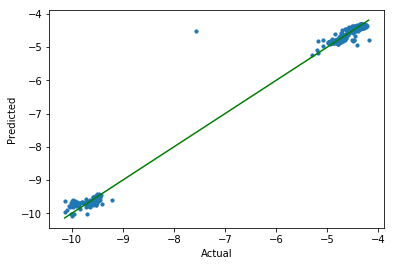

In [625]:
rf_params = dict(n_estimators=5,max_depth=5,max_features=5,min_samples_leaf=2,min_samples_split=5)
gbr_params = dict(n_estimators=4,max_depth=3,max_features=2,min_samples_leaf=2,min_samples_split=5,learning_rate=0.9)
rf = RandomForestRegressor(**rf_params)
#gbr = GradientBoostingRegressor(learning_rate=0.9,**gbr_params)
mv.KFold_pva(rf,X_ind,y)

In [624]:
#dir(rf)
np.sum(np.sort(gbr.feature_importances_)[::-1][:5])

0.8433040060777289

In [515]:
sort_idx = np.argsort(rf.feature_importances_)[::-1]
n_top_feat = 5

print(f'Top {n_top_feat} features total importance:', np.sum(rf.feature_importances_[sort_idx[:n_top_feat]]))
print(list(X_num_df.columns[sort_idx[:n_top_feat]]))
rf.feature_importances_[sort_idx[:n_top_feat]]

Top 5 features total importance: 0.9924299290778285
['comp_oxmin_tot_charge', 'comp_oxmin_OS_std', 'comp_oxrange_alat_hardsphere', 'comp_oxmean_ion_energy_std', 'comp_oxmean_X_cat_mean']


array([0.49556354, 0.24750683, 0.24600922, 0.00191348, 0.00143686])

In [645]:
repeat = 50
n_estimators = 5
top_feat_importance = np.empty(repeat)
top_features = []
test_scores = np.empty(repeat)

for i in range(repeat):
    params = dict(n_estimators=n_estimators,max_depth=5,max_features=5,min_samples_leaf=2,min_samples_split=5)
    rf = RandomForestRegressor(**params)
    act, pred, train, test = mv.KFold_cv(rf,X_ind,y)
    test_scores[i] = np.mean(test)
    sort_idx = np.argsort(rf.feature_importances_)[::-1]
    top_feat_importance[i] = np.sum(rf.feature_importances_[sort_idx[:n_estimators]])
    top_features += list(X_ind_df.columns[sort_idx[:n_estimators]])

In [646]:
top_feat_importance

array([0.98686918, 0.98759625, 0.99188113, 0.99236503, 0.9924705 ,
       0.98933003, 0.99154515, 0.99174376, 0.88291706, 0.98882608,
       0.99241214, 0.97919123, 0.99055208, 0.989435  , 0.97869824,
       0.9894839 , 0.99117479, 0.99460915, 0.98952067, 0.98823524,
       0.98803472, 0.99207291, 0.98863959, 0.99122762, 0.98958478,
       0.99228957, 0.9890801 , 0.98977285, 0.98982004, 0.98838119,
       0.98859793, 0.99068374, 0.99168225, 0.9904736 , 0.99083004,
       0.98979253, 0.98879567, 0.93592101, 0.98755221, 0.99229726,
       0.99207858, 0.99244022, 0.99455744, 0.99214906, 0.98940517,
       0.98810334, 0.98834418, 0.98876639, 0.98977308, 0.99105281])

In [648]:
counter = dict(collections.Counter(top_features))
#list(counter.keys())[np.argsort(list(counter.values()))]
sorted_feat = sorted(counter.items(),key=lambda item: item[1])[::-1]
sorted_feat

[('comp_valence_unfilled_p_std', 15),
 ('Bsite_oxstd_ion_energy_std', 11),
 ('comp_H_fus_mean', 10),
 ('comp_X_mean', 10),
 ('Bsite_H_vap_std', 8),
 ('Bsite_oxmean_ion_energy_mean', 8),
 ('Bsite_oxmean_ion_energy_std', 8),
 ('comp_mass_mean', 8),
 ('Bsite_melt_temp_std', 8),
 ('comp_mendeleev_mean', 7),
 ('comp_oxrange_uc_vol_free', 7),
 ('Bsite_oxrange_ion_energy_std', 7),
 ('comp_oxstd_goldschmidt', 6),
 ('comp_oxmax_uc_vol_free', 6),
 ('Bsite_oxmean_X_cat_std', 6),
 ('Bsite_oxstd_r_std', 6),
 ('comp_oxmean_tot_charge', 6),
 ('Bsite_oxmax_ion_energy_std', 6),
 ('comp_oxmean_ion_energy_mean', 6),
 ('comp_oxstd_r_mean', 6),
 ('Bsite_mass_std', 6),
 ('comp_oxmean_r_mean', 6),
 ('comp_oxmax_r_mean', 5),
 ('Bsite_mendeleev_std', 5),
 ('Bsite_HOMO_energy', 5),
 ('Bsite_oxmax_X_cat_std', 5),
 ('Bsite_X_std', 5),
 ('comp_oxmin_r_mean', 5),
 ('Bsite_oxmean_OS_std', 5),
 ('comp_oxstd_r_crit', 4),
 ('comp_oxstd_tau', 4),
 ('Bsite_oxmax_r_std', 4),
 ('Bsite_oxmax_OS_std', 4),
 ('comp_oxstd_uc_vo

In [649]:
common_feat = [feat for feat,count in sorted_feat[:10]]#[feat for feat,count in counter.items() if count >= 9]
common_feat
X_ind_df.loc[:,common_feat].head()

,comp_valence_unfilled_p_std,Bsite_oxstd_ion_energy_std,comp_H_fus_mean,comp_X_mean,Bsite_H_vap_std,Bsite_oxmean_ion_energy_mean,Bsite_oxmean_ion_energy_std,comp_mass_mean,Bsite_melt_temp_std,comp_mendeleev_mean
1_500C_dry_1251,1.283025,11.201383,4.680685,2.610105,97.793766,65.378570,22.652482,48.827043,149.371438,65.318849
2_500C_dry_1251,1.282999,11.199666,4.680835,2.609755,97.808660,65.377458,22.650509,48.844376,149.366899,65.307168
3_500C_dry_1251,1.282972,11.197750,4.681036,2.609401,97.825648,65.376441,22.648556,48.861800,149.365359,65.295429
4_500C_dry_1251,1.283236,11.509287,4.674036,2.611186,94.224116,65.235505,22.571911,48.772526,144.578567,65.347051
5_500C_dry_1251,1.283187,11.473304,4.675823,2.610947,94.654346,65.256132,22.586906,48.786404,145.219707,65.340611


(array([0.99643427, 0.99781362, 0.99901659, 0.99808039, 0.99617343]),
 array([0.99726129, 0.99665472, 0.97891652, 0.99697728, 0.99787553]))

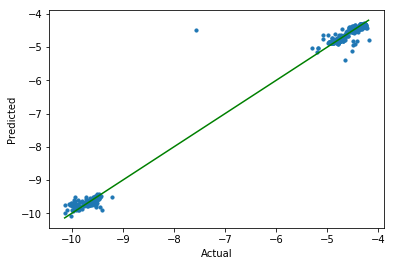

In [650]:
params = dict(n_estimators=5,max_depth=5,max_features=5,min_samples_leaf=2,min_samples_split=5)
rf = RandomForestRegressor(**params)
mv.KFold_pva(rf,X_ind_df.loc[:,common_feat].values,y)

(array([0.99702155, 0.99703257, 0.99858097, 0.99664567, 0.9972451 ]),
 array([0.99751299, 0.9946653 , 0.97845412, 0.99664665, 0.99737325]))

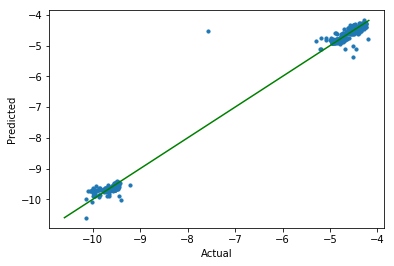

In [725]:
X_com_df = X_ind_df.loc[:,common_feat]
gbr = GradientBoostingRegressor(**gbr_params)
mv.KFold_pva(gbr,X_com_df.values,y)

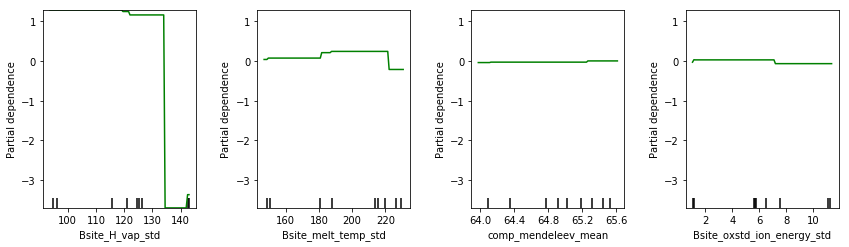

In [726]:
gbr_features = np.argsort(gbr.feature_importances_)[:-5:-1]
fig, ax = plt.subplots(figsize=(13,5))
fig,axes = plot_partial_dependence(gbr,X_com_df.values,features=gbr_features,feature_names=X_com_df.columns,n_cols=4,ax=ax)


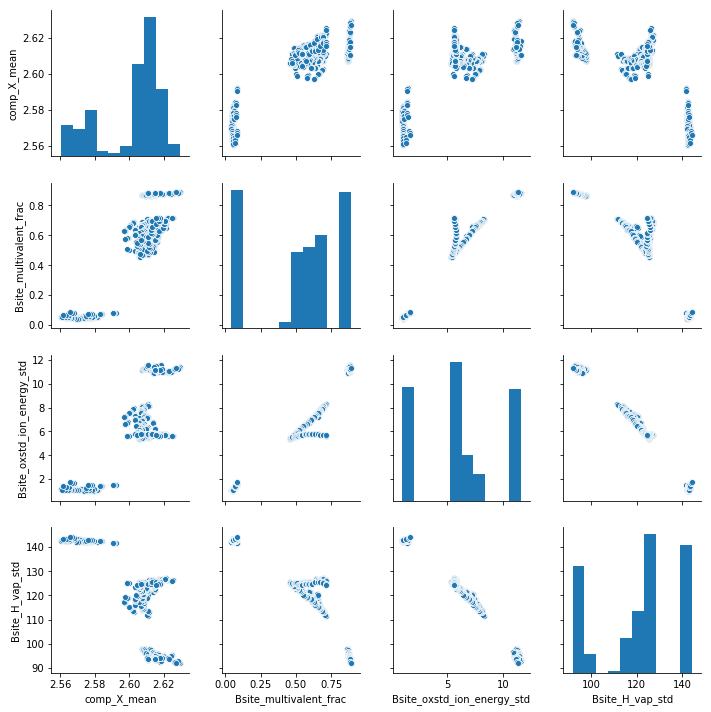

In [727]:
sns.pairplot(fX_df,vars=['comp_X_mean','Bsite_multivalent_frac','Bsite_oxstd_ion_energy_std','Bsite_H_vap_std'])

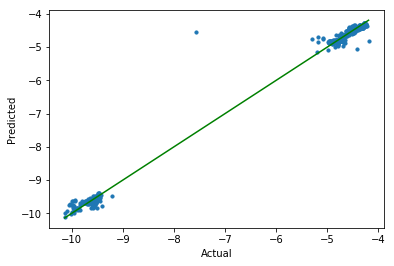

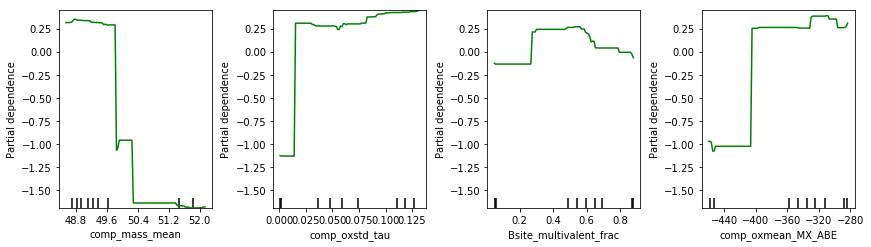

In [737]:
cols = ['Bsite_multivalent_frac','comp_mass_mean','comp_oxmean_MX_ABE','Bsite_HOMO_energy','comp_oxstd_tau']
#cols.remove('comp_oxmean_MX_ABE')
gbr_params = dict(n_estimators=4,max_depth=3,max_features=len(cols),min_samples_leaf=2,min_samples_split=5,learning_rate=0.9)
gbr = GradientBoostingRegressor()#**gbr_params)
mv.KFold_pva(gbr,X_num_df[cols].values,y)

gbr_features = np.argsort(gbr.feature_importances_)[:-5:-1]

fig, ax = plt.subplots(figsize=(13,5))
fig,axes = plot_partial_dependence(gbr,X_num_df[cols].values,features=gbr_features,
                                   feature_names=X_num_df[cols].columns,n_cols=4,ax=ax)

In [742]:
interact_manual(
    mv.plot_loco_cv,
    estimator_class=fixed(GradientBoostingRegressor),
    X = fixed(X_num_df[cols].values),
    y = fixed(y),
    clusters = fixed(clusters),
    n_estimators = (1,10),
    max_depth = (1,10),
    max_features = [1,2,3,4,None],
    learning_rate = (0.1,1.0),
    min_samples_leaf = (1,10),
    min_samples_split = (1,10),
    ncol = fixed(4)
)

interactive(children=(Checkbox(value=True, description='standardize'), Checkbox(value=False, description='sharex'), Checkbox(value=False, description='sharey'), IntSlider(value=5, description='n_estimators', max=10, min=1), IntSlider(value=5, description='max_depth', max=10, min=1), Dropdown(description='max_features', options=(1, 2, 3, 4, None), value=1), FloatSlider(value=0.55, description='learning_rate', max=1.0, min=0.1), IntSlider(value=5, description='min_samples_leaf', max=10, min=1), IntSlider(value=5, description='min_samples_split', max=10, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function helpers.model_eval.plot_loco_cv>

In [693]:
sorted_feat

[('comp_valence_unfilled_p_std', 15),
 ('Bsite_oxstd_ion_energy_std', 11),
 ('comp_H_fus_mean', 10),
 ('comp_X_mean', 10),
 ('Bsite_H_vap_std', 8),
 ('Bsite_oxmean_ion_energy_mean', 8),
 ('Bsite_oxmean_ion_energy_std', 8),
 ('comp_mass_mean', 8),
 ('Bsite_melt_temp_std', 8),
 ('comp_mendeleev_mean', 7),
 ('comp_oxrange_uc_vol_free', 7),
 ('Bsite_oxrange_ion_energy_std', 7),
 ('comp_oxstd_goldschmidt', 6),
 ('comp_oxmax_uc_vol_free', 6),
 ('Bsite_oxmean_X_cat_std', 6),
 ('Bsite_oxstd_r_std', 6),
 ('comp_oxmean_tot_charge', 6),
 ('Bsite_oxmax_ion_energy_std', 6),
 ('comp_oxmean_ion_energy_mean', 6),
 ('comp_oxstd_r_mean', 6),
 ('Bsite_mass_std', 6),
 ('comp_oxmean_r_mean', 6),
 ('comp_oxmax_r_mean', 5),
 ('Bsite_mendeleev_std', 5),
 ('Bsite_HOMO_energy', 5),
 ('Bsite_oxmax_X_cat_std', 5),
 ('Bsite_X_std', 5),
 ('comp_oxmin_r_mean', 5),
 ('Bsite_oxmean_OS_std', 5),
 ('comp_oxstd_r_crit', 4),
 ('comp_oxstd_tau', 4),
 ('Bsite_oxmax_r_std', 4),
 ('Bsite_oxmax_OS_std', 4),
 ('comp_oxstd_uc_vo

# Smaller initial feature set

In [743]:
pp.set_featurize_options(sites='B',ox_stats=['mean','std'],ep_stats=['mean','std_dev'])


loaded featurizers
